# Projekt : Uczenie maszynowe - Przewidywanie cukrzycy
## Damian Forma, Michał Fuczik, Jakub Dębski

Importowanie wszystkich potrzebnych bibliotek i pakietów

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import itertools

from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('_mpl-gallery')

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

## Nasze dane : Diabetes
Dane zawierają informacje o 768 osobach i ich:

* Pregnancies - Liczba zajść w ciążę

* Glucose - Stężenie glukozy w osoczu w ciągu 2 godzin w doustnym teście tolerancji glukozy

* BloodPressure - Rozkurczowe ciśnienie krwi (mm Hg)

* SkinTickness - Grubość fałdu skórnego mięśnia trójgłowego uda (mm)

* Insulin -  2-godzinna insulina w surowicy (mu U/ml)

* BMI - Wskaźnik masy ciała (waga w kg/(wzrost w m)2)

* DiabetesPedigreeFunction - Funkcja rodowodu cukrzycy (funkcja oceniająca prawdopodobieństwo wystąpienia cukrzycy na podstawie wywiadu rodzinnego)

* Age - Wiek (lata)

* outcome - Zmienna klasowa (0 w przypadku osób bez cukrzycy, 1 w przypadku cukrzycy)

In [ ]:
data = pd.read_csv("diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Przegląd danych
Tearz spójrzmy na nasze dane żeby zobaczyc jak jak wyglądają ich statystyki opisowe oraz jaki jest typ naszych kolumn

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
df = pd.DataFrame(data)

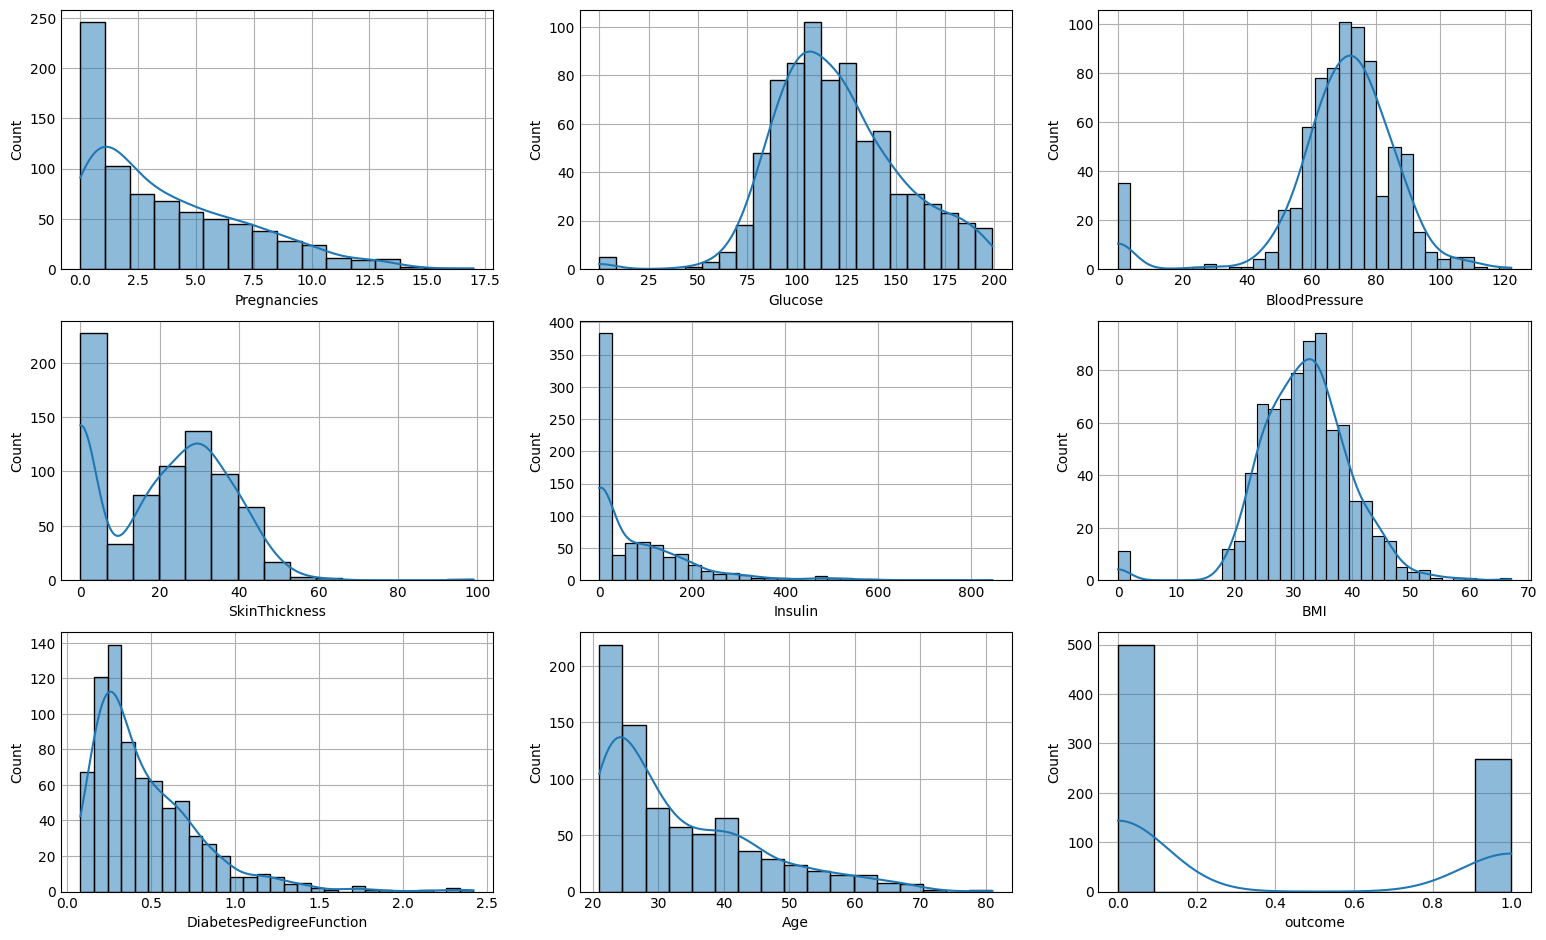

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(3,3,figsize=(15,9))
for i, col in enumerate(df):
    sns.histplot(df[col], kde=True, ax=ax[i//3, i%3])
    # plt.title(f"{col} ditribution", fontsize=14, fontweight='bold', c='r')
plt.show()

Możemy zuważyć że w niektóre kolumny zwiarają wartości zero co w niektórych przypadkach może wydawać się "dziwne" jak chociażby takie wartości w kolumnie z pomiarem ciśnienia krwi, poziom cukru czy BMI. Ale przyjrzyjmy się bardziej kolumon SkinTickness oraz Insulin.

Spróbujmy przyjrzeć się tym kolumnom pojedyńczo, czy te wartości mają jakieś znaczenie dla osób z cukrzyca i bez cukrzycy.

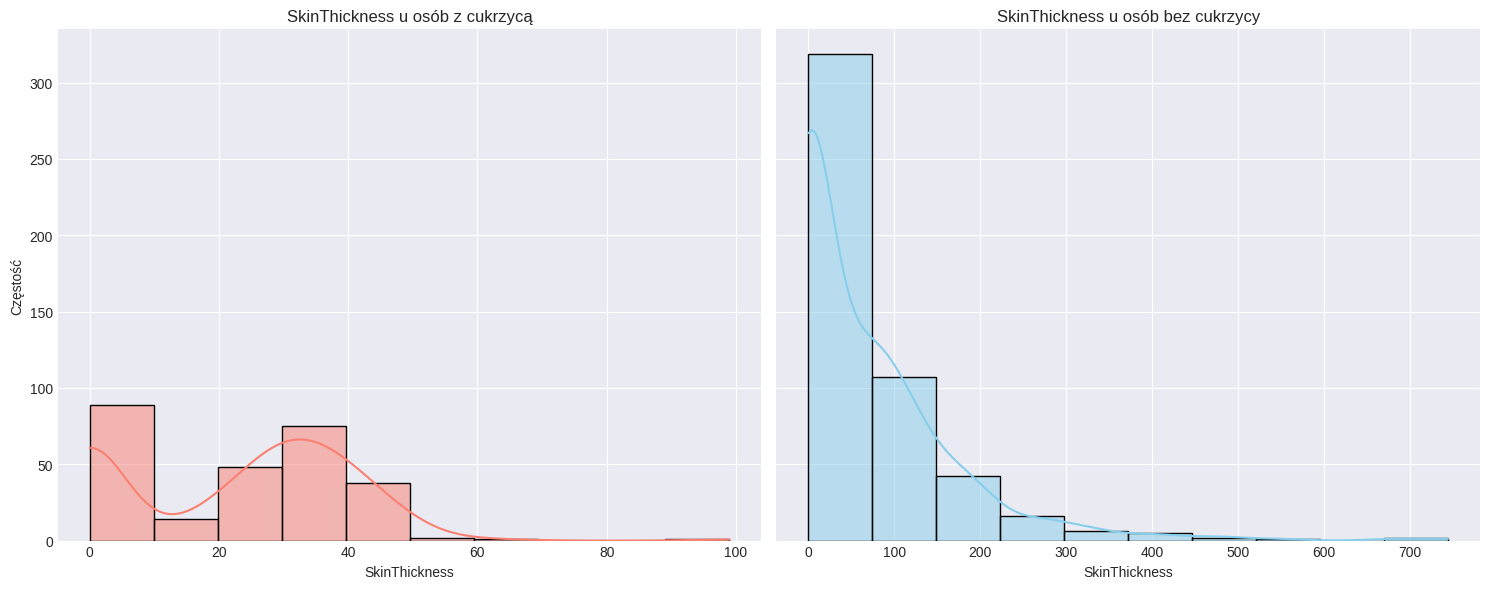

In [ ]:
# Podział danych na osoby z cukrzycą i bez
diabetes_df = df[df['outcome'] == 1]
no_diabetes_df = df[df['outcome'] == 0]

# Ustawienie stylu wykresów
plt.style.use('seaborn-darkgrid')

# Tworzenie wykresów
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Wykres dla osób z cukrzycą
sns.histplot(diabetes_df['SkinThickness'], bins=10, kde=True, ax=axes[0], color='salmon')
axes[0].set_title('SkinThickness u osób z cukrzycą')
axes[0].set_xlabel('SkinThickness')
axes[0].set_ylabel('Częstość')

# Wykres dla osób bez cukrzycy
sns.histplot(no_diabetes_df['Insulin'], bins=10, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('SkinThickness u osób bez cukrzycy')
axes[1].set_xlabel('SkinThickness')
axes[1].set_ylabel('Częstość')

plt.tight_layout()
plt.show()

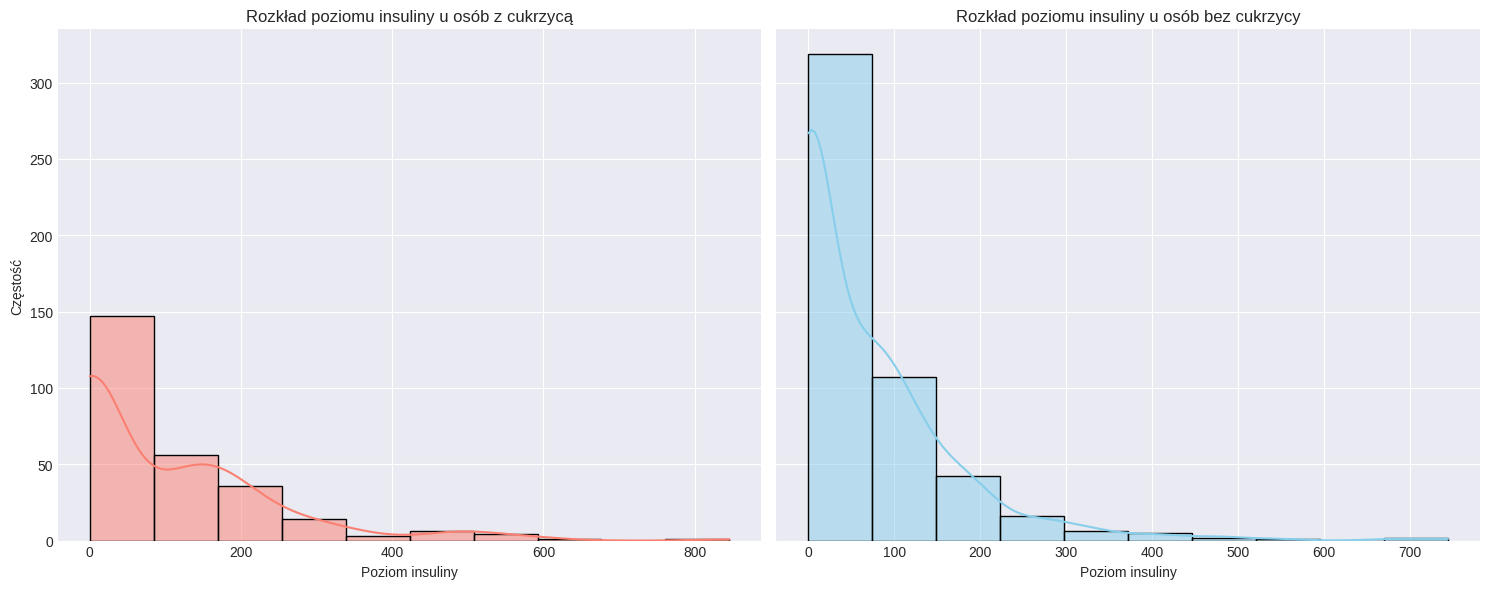

In [ ]:
# Podział danych na osoby z cukrzycą i bez
diabetes_df = df[df['outcome'] == 1]
no_diabetes_df = df[df['outcome'] == 0]

# Ustawienie stylu wykresów
plt.style.use('seaborn-darkgrid')

# Tworzenie wykresów
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Wykres dla osób z cukrzycą
sns.histplot(diabetes_df['Insulin'], bins=10, kde=True, ax=axes[0], color='salmon')
axes[0].set_title('Rozkład poziomu insuliny u osób z cukrzycą')
axes[0].set_xlabel('Poziom insuliny')
axes[0].set_ylabel('Częstość')

# Wykres dla osób bez cukrzycy
sns.histplot(no_diabetes_df['Insulin'], bins=10, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Rozkład poziomu insuliny u osób bez cukrzycy')
axes[1].set_xlabel('Poziom insuliny')
axes[1].set_ylabel('Częstość')

plt.tight_layout()
plt.show()

Wykresy pokazały że na wartości może wpływac to czy ktoś ma cukrzyce czy nie więc na razie zostawiamy te wartości. Spójrzmy jeszcze na wykresy pudełkowe naszych kolumn z podziałem na osoby z cukrzyca i bez cukrzycy.

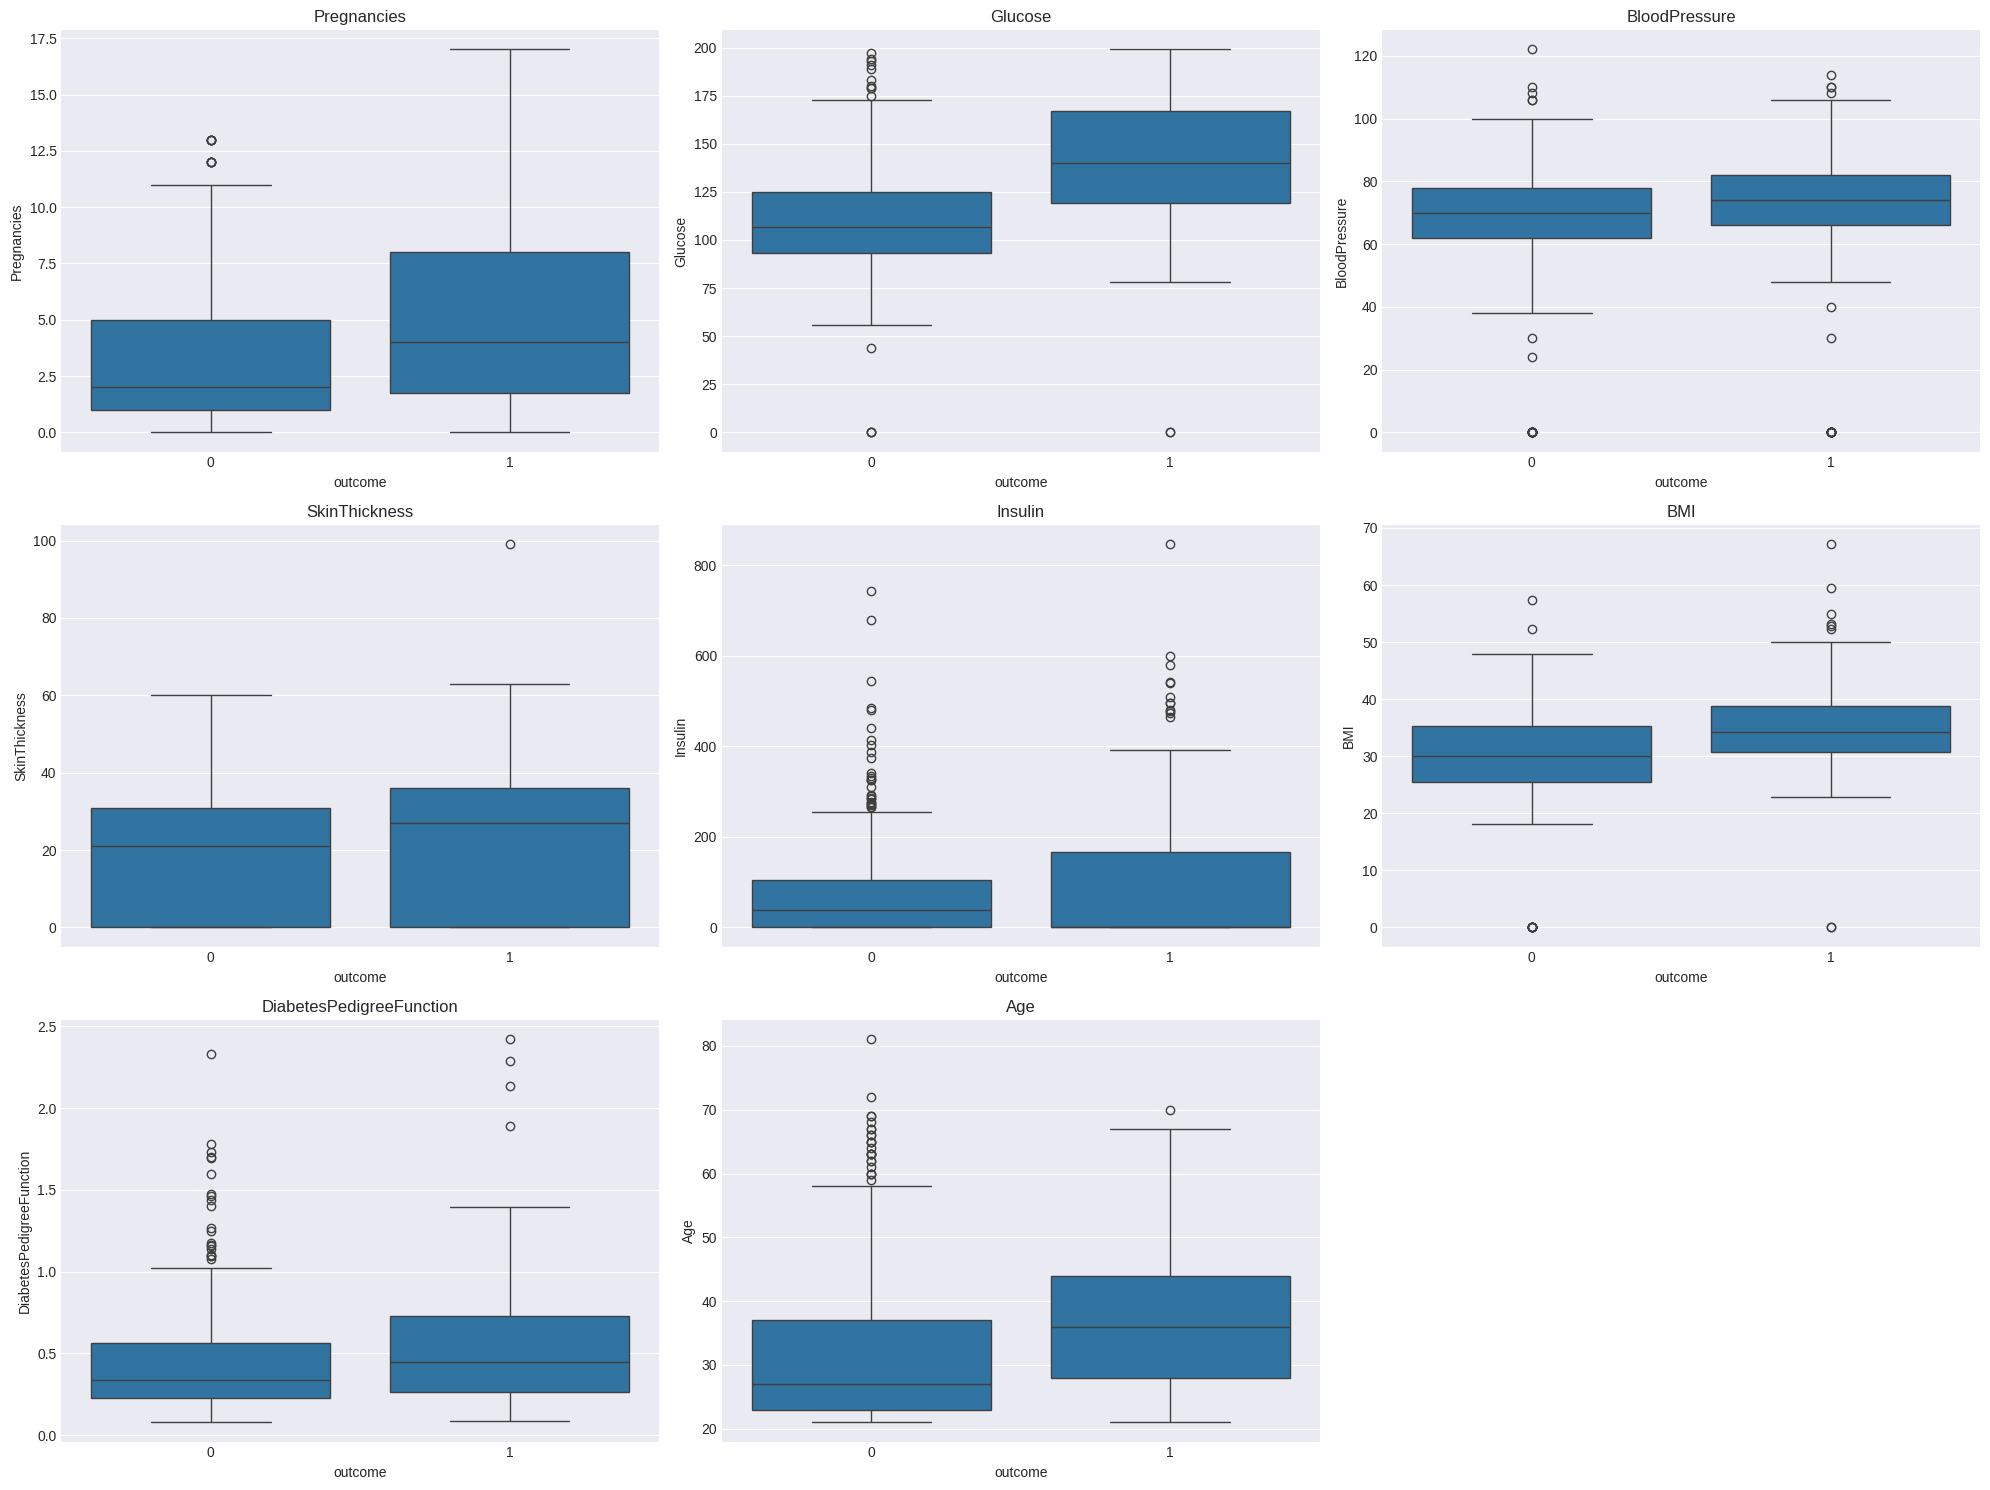

In [ ]:
# Lista kolumn do stworzenia wykresów pudełkowych
columns = df.columns[:-1]  # Wszystkie kolumny z wyjątkiem 'Outcome'

# Tworzenie wykresów pudełkowych
plt.figure(figsize=(20, 15))

for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='outcome', y=col, data=df)
    plt.title(f'{col}')

plt.tight_layout()
plt.show()

Na wykresach pudełkowych możemy zauważyć że praktycznie dla każdej zmiennej osoby chorujące na cukrzyce mają wyższe parametry niż osoby zdrowe

## Czyszczenie i przygotowanie danych

Przejdzimy teraz do czyszczenia i przygotowania naszych danych.

Na początku sprawdzimy czy nie ma brakujących danych w naszych kolumnach

In [ ]:
df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
outcome                     0
dtype: int64

Wszystkie wartości są równe zera oznacza to że nie ma brakujących danych w kolumnach

In [ ]:
df.duplicated().sum()

0

Teraz zmienimy nasze zera w kolumnach Glucose, BloodPressure oraz BMI na wartości `nan`

In [ ]:
df1 = df.copy()
zero_col = ['Glucose','BloodPressure','BMI']
df1[zero_col] = df1[zero_col].replace(0, np.nan)

In [ ]:
df1.isna().sum()

Pregnancies                  0
Glucose                      5
BloodPressure               35
SkinThickness                0
Insulin                      0
BMI                         11
DiabetesPedigreeFunction     0
Age                          0
outcome                      0
dtype: int64

Następnie zastępujemy wartości `nan` średnią z danej kolumny

In [ ]:
for col in ['BMI','BloodPressure', 'Glucose']:
    mean_col = np.mean(df1[df1[col].notna()][col])
    df1[col] = df1[col].fillna(mean_col)

Teraz sprawdzimy macierz korelacji naszych zmiennych oraz wykres zalezności par kolumn dla osób z cukrzyca i bez cukrzycy

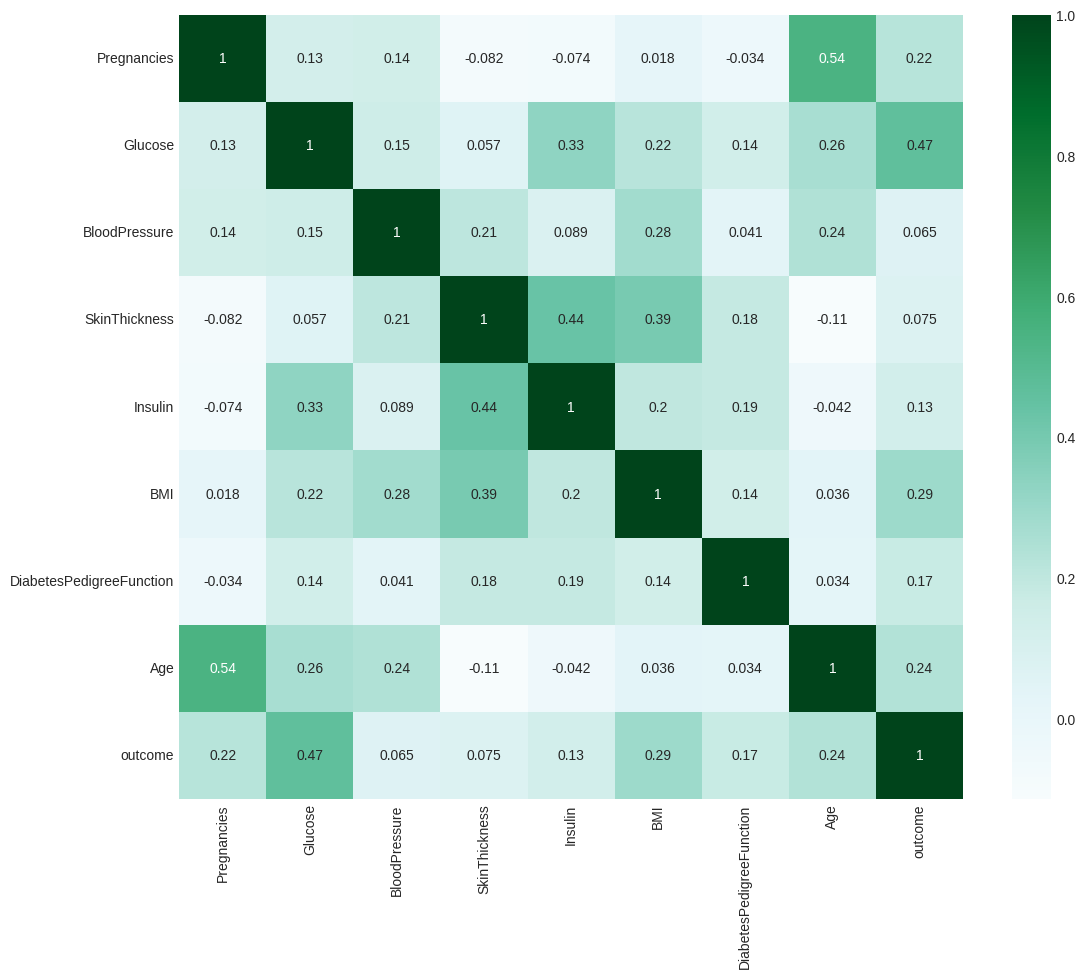

In [ ]:
%matplotlib inline
plt.figure(figsize = (10,8))
sns.heatmap(data.corr(),annot=True,  cmap='BuGn')
plt.show()

Możemy zobaczyć w w żadnym przypadku naszych danych nie wystepuje silna korelacja, natomiast największa korelacja wystepuje między wiekiem a liczba ciąży oraz poziom cukru czyli glukozą a kolumną wynikową (outcome)

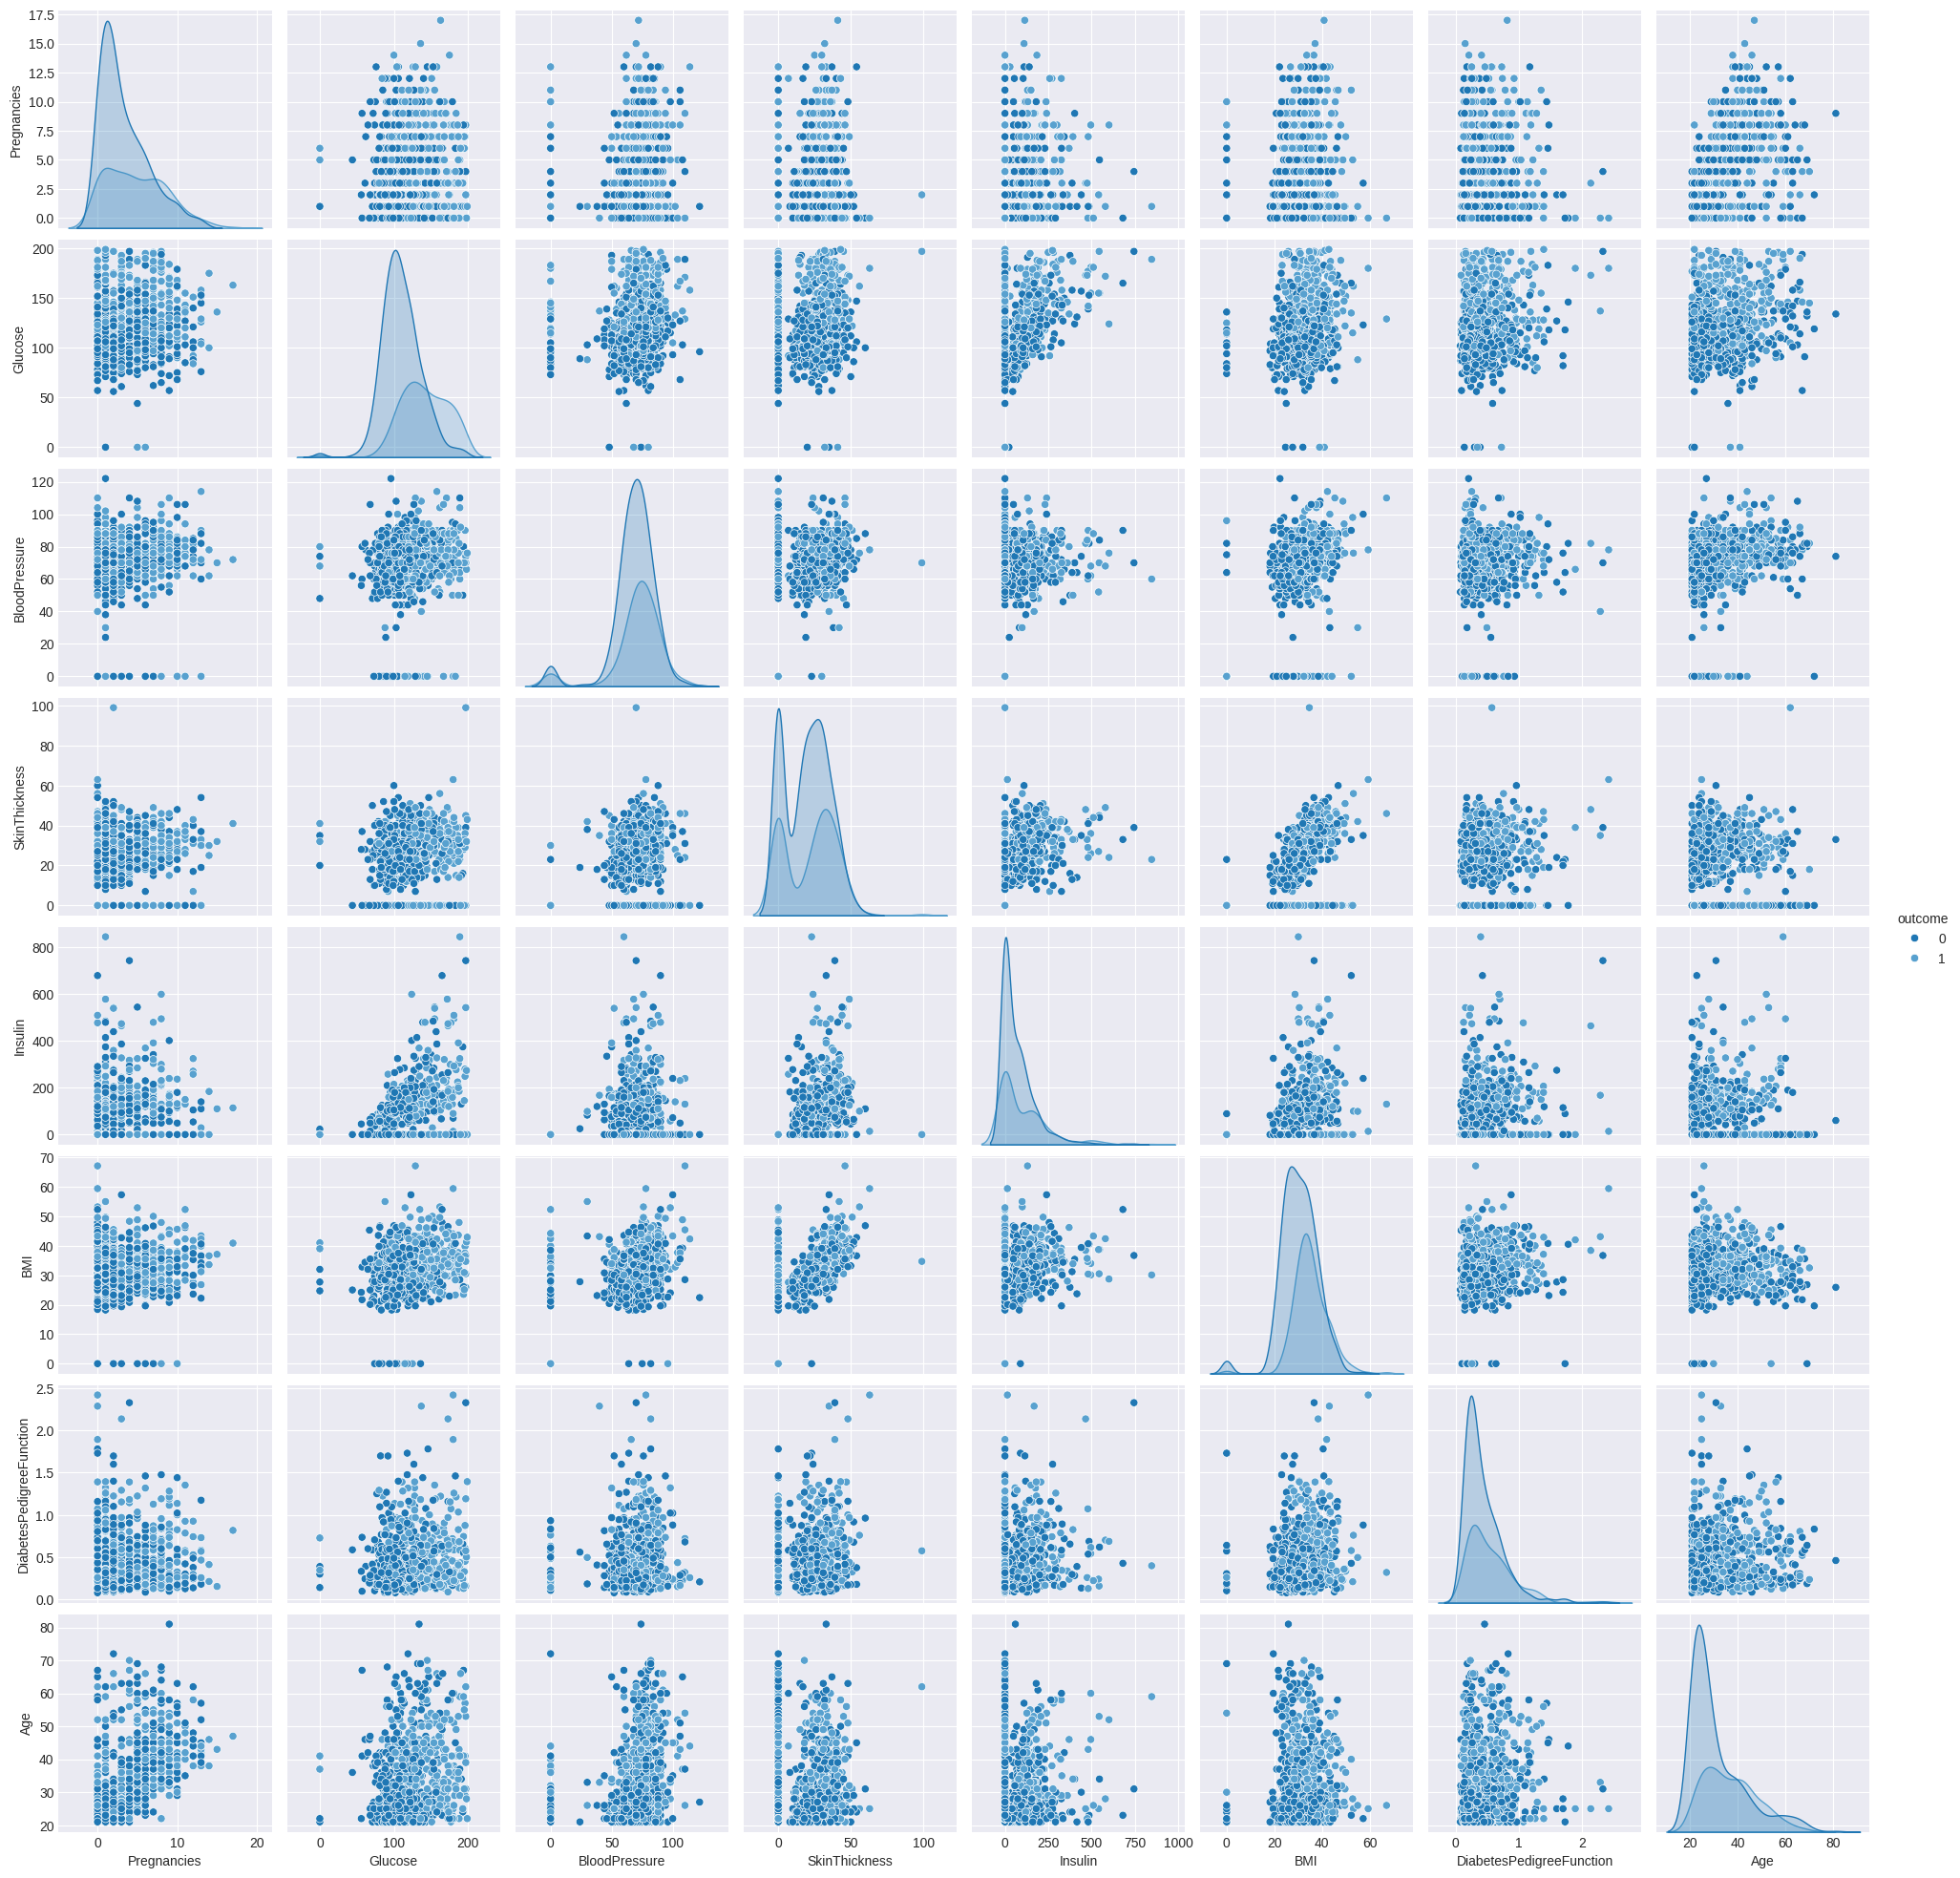

In [ ]:
sns.pairplot(data=df, hue='outcome')
plt.show()

Na wykresie zależności kolumn dla osób z cukrzyca i osób bez cukrzycy dane na każdym wykresie punktowym są raczej "zbite" nie ma większego podziału na osoby chore i zdrowe.

Następnym i ostatnim krokiem w przygotowaniu danych będzie podział danych na zbiór testowy i treningowy w proporcji 20% do 80%.

In [ ]:
y = df1['outcome']
X = df1.drop('outcome',axis =1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = df1['outcome'] )

# Model 1

Tworzymy model i ćwiczymy go, a następnie robimy predykcje naszego modelu

In [ ]:
model = LogisticRegression()
model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

In [ ]:
y_predict

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

Teraz w celu podsumowania modelu zrobimy pokazemy macierz korelacji , krzywą ROC oraz raport modelu, który zawiera informacje takie jak accuracy, f1-score, precision czy recall.

* Dokładność (Accuracy): Dokładność reprezentuje ogólny wskaźnik poprawności przewidywań modelu. Wskazuje ona proporcję poprawnie sklasyfikowanych przypadków w stosunku do całkowitej liczby danych.

* Czułość (Recall): Czułość mierzy proporcję rzeczywistych przypadków cukrzycy, które są poprawnie identyfikowane przez model. Pokazuje, jak dobrze model wychwytuje prawdziwe przypadki pozytywne cukrzycy.

* Precyzja (Precision): Precyzja oblicza proporcję przewidywanych przypadków cukrzycy, które są faktycznie prawdziwymi przypadkami pozytywnymi. Wskazuje dokładność pozytywnych przewidywań modelu dotyczących cukrzycy.

* Wynik F1 (F1 Score): Wynik F1 jest średnią harmoniczną czułości i precyzji. Zapewnia zrównoważony pomiar, uwzględniając zarówno czułość, jak i precyzję w równym stopniu, oceniając ogólną wydajność modelu.

* AUC (Pole pod krzywą): AUC reprezentuje pole pod krzywą ROC (Receiver Operating Characteristic). Odrzwierciedla zdolność modelu do rozróżniania między klasami i dostarcza ogólnej miary wydajności.

In [ ]:
cm = confusion_matrix(Y_test, y_predict)
cm

array([[84, 16],
       [25, 29]])

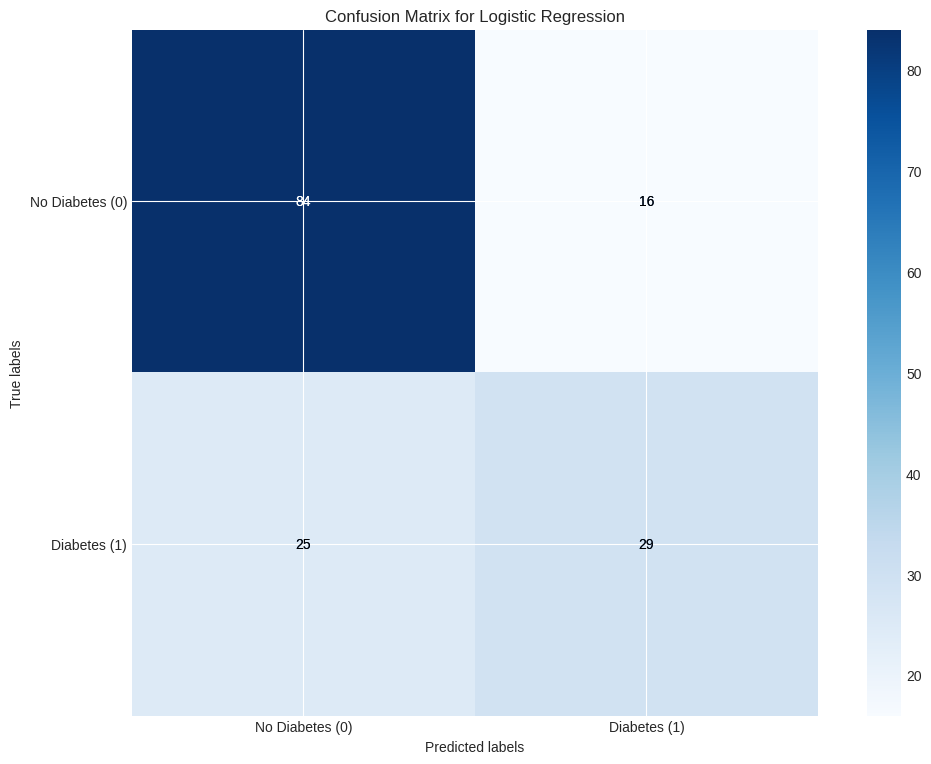

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, y_predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)


fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for Logistic Regression')


plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.yticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2. else 'black')

plt.show()

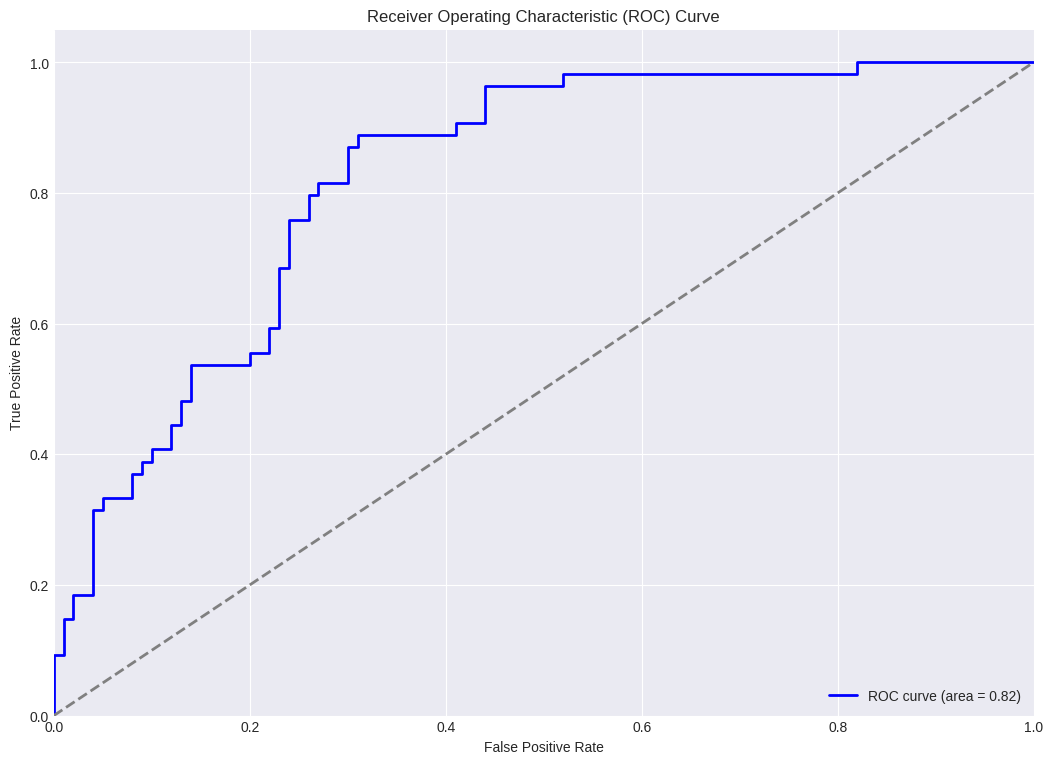

Model Summary:
ROC AUC: 0.8242592592592592


In [ ]:
from sklearn.metrics import  roc_curve, roc_auc_score
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = roc_auc_score(Y_test, y_prob)
accuracy = accuracy_score(Y_test, y_predict)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Podsumowanie modelu
print("Model Summary:")
print(f"ROC AUC: {roc_auc:}")

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(Y_test,y_predict))
print("Confusion Matrix:\n",confusion_matrix(Y_test,y_predict))
print("Training Score:\n",model.score(X_train,Y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(Y_test,y_predict))
print("R2 score is:\n",r2_score(Y_test,y_predict))

Classification Report is:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154

Confusion Matrix:
 [[84 16]
 [25 29]]
Training Score:
 79.96742671009773
Mean Squared Error:
 0.2662337662337662
R2 score is:
 -0.16925925925925922


In [ ]:
accuracy

0.7337662337662337

Wnioski: Model 1

Macierz Pomyłek:

Macierz Pomyłek:

Model poprawnie sklasyfikował
29 TP pozytywnych przypadków oraz
84 TN negatywnych przypadków.
Zanotowano
25 FP fałszywych pozytywów oraz
16 FN fałszywych negatywów, co może sugerować możliwości do poprawy.

Krzywa ROC:

Wartość AUC wynosi
0.82, co wskazuje na zadowalającą zdolność modelu do rozróżniania między klasami.

Raport z Modelu:

* Dokładność modelu wynosi
73%, co oznacza, że model poprawnie klasyfikuje większość przypadków.
* Czułość modelu wynosi
54%, co oznacza, że model dobrze identyfikuje rzeczywiste pozytywne przypadki.
* Precyzja modelu wynosi
64%, co wskazuje na wysoką dokładność w przewidywaniu pozytywnych przypadków.
* F1 Score wynosi
59%, co świadczy o zrównoważonej wydajności modelu.

## Model 2

W naszym pierwszym modelu działaliśmy nie zmieniając nic w kolumnie Inslulin i SkinThickness. Teraz zamienimy zera w tych kolumnach na wartości średnie w danej kolumnie i zobaczymy jak będzie się zachowywał nasz model

In [ ]:
zero_col = ['Insulin','SkinThickness']
df1[zero_col] = df1[zero_col].replace(0, np.nan)
df1.isna().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               227
Insulin                     374
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
outcome                       0
dtype: int64

In [ ]:
for col in ['Insulin','SkinThickness']:
    mean_col = np.mean(df1[df1[col].notna()][col])
    df1[col] = df1[col].fillna(mean_col)

In [ ]:
y = df1['outcome']
X = df1.drop('outcome',axis =1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = df1['outcome'] )

In [ ]:
model.fit(X_train, Y_train)
y_predict1 = model.predict(X_test)

In [ ]:
y_predict1

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

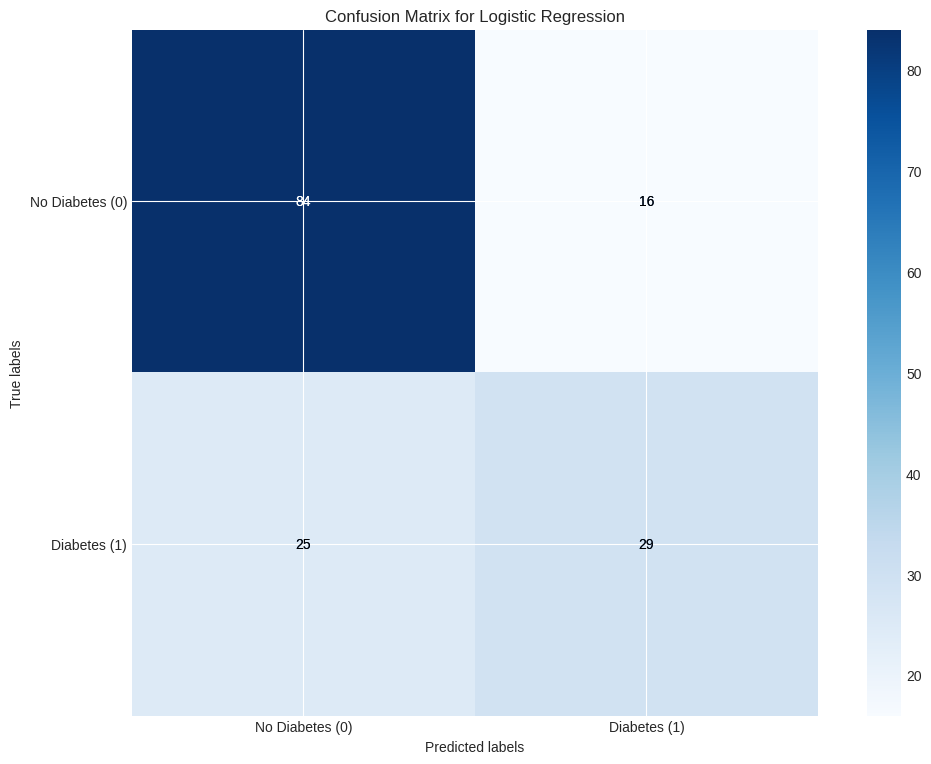

In [ ]:
cm = confusion_matrix(Y_test, y_predict1, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)


fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for Logistic Regression')


plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.yticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2. else 'black')

plt.show()

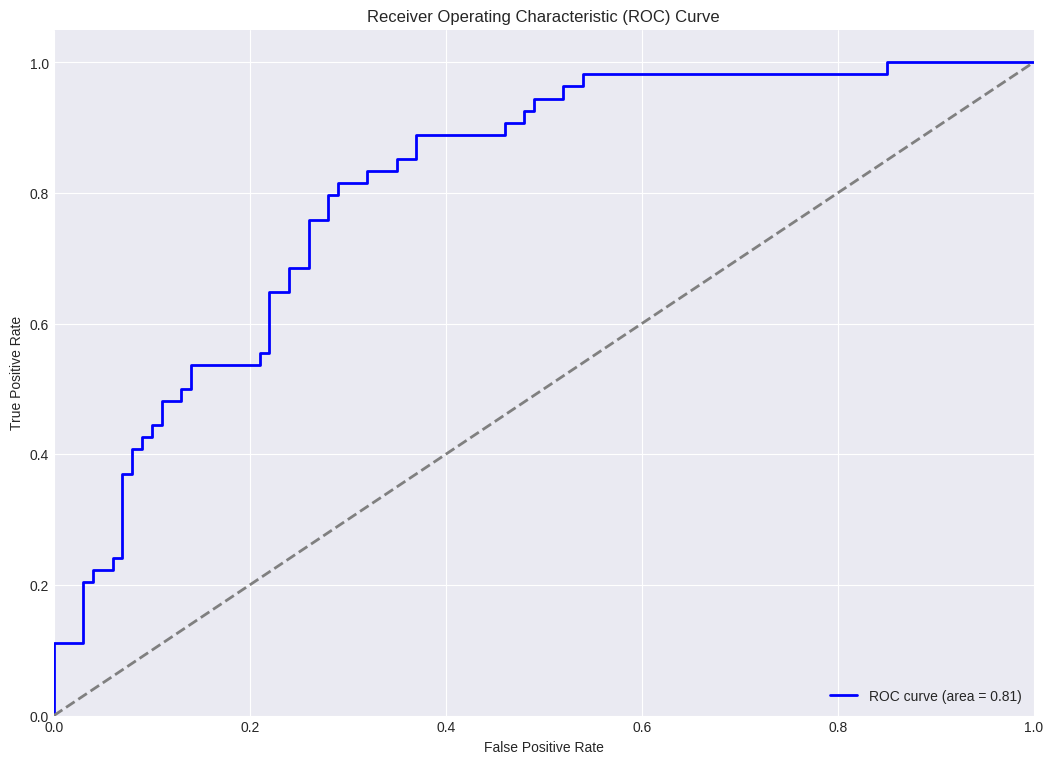

Model Summary:
ROC AUC: 0.812037037037037


In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = roc_auc_score(Y_test, y_prob)
accuracy1 = accuracy_score(Y_test, y_predict1)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Podsumowanie modelu
print("Model Summary:")
print(f"ROC AUC: {roc_auc:}")

In [ ]:
print("Classification Report is:\n",classification_report(Y_test,y_predict1))
print("Confusion Matrix:\n",confusion_matrix(Y_test,y_predict1))
print("Training Score:\n",model.score(X_train,Y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(Y_test,y_predict1))
print("R2 score is:\n",r2_score(Y_test,y_predict1))

Classification Report is:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154

Confusion Matrix:
 [[84 16]
 [25 29]]
Training Score:
 78.99022801302932
Mean Squared Error:
 0.2662337662337662
R2 score is:
 -0.16925925925925922


In [ ]:
accuracy1

0.7337662337662337

Wnioski: Model 2

Macierz Pomyłek:

Model poprawnie sklasyfikował
29 TP pozytywnych przypadków oraz
84 TN negatywnych przypadków.
Zanotowano
16 FP fałszywych pozytywów oraz
25 FN fałszywych negatywów, co może sugerować możliwości do poprawy.

Krzywa ROC:

Wartość AUC wynosi
0.81%, co wskazuje na dobrą zdolność modelu do rozróżniania między klasami.

Raport z Modelu:

* Dokładność modelu wynosi 73.37%, co oznacza, że model poprawnie klasyfikuje większość przypadków.
* Czułość modelu wynosi 0,64, co oznacza, że model średnio identyfikuje rzeczywiste pozytywne przypadki.
* Precyzja modelu wynosi 0.54, co wskazuje na niską dokładność w przewidywaniu pozytywnych przypadków.
* F1 Score wynosi 0.59, co świadczy o niewielkiej wydajności modelu.


Dokładności modelu 1 i modelu 2 sa niemal indentyczne.

## Model 3

W trzecim modelu użyjemy danych ustandaryzowanych i działamy jak w poprzednich przypadkach

In [ ]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(X)
x_norm

array([[ 0.63994726,  0.86510807, -0.03351824, ...,  0.16629174,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20616153, -0.52985903, ..., -0.85253118,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.0158134 , -0.69530596, ..., -1.33283341,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.0225789 , -0.03351824, ..., -0.91074963,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14180757, -1.02619983, ..., -0.34311972,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94314317, -0.19896517, ..., -0.29945588,
        -0.47378505, -0.87137393]])

In [ ]:
x= pd.DataFrame(x_norm, index=X.index, columns=X.columns)
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,6.655021e-01,-3.345079e-16,0.166292,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-1.746338e-02,-3.345079e-16,-0.852531,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,8.087936e-16,-3.345079e-16,-1.332833,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-7.004289e-01,-7.243887e-01,-0.634212,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,6.655021e-01,1.465506e-01,1.548980,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.680125,0.297376,2.145261e+00,2.877840e-01,0.064409,-0.908682,2.532136
764,-0.547919,0.010298,-0.198965,-2.451185e-01,-3.345079e-16,0.632039,-0.398282,-0.531023
765,0.342981,-0.022579,-0.033518,-7.004289e-01,-5.125386e-01,-0.910750,-0.685193,-0.275760
766,-0.844885,0.141808,-1.026200,8.087936e-16,-3.345079e-16,-0.343120,-0.371101,1.170732


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
model.fit(X_train, Y_train)
y_predict2 = model.predict(X_test)

In [ ]:
y_predict2

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

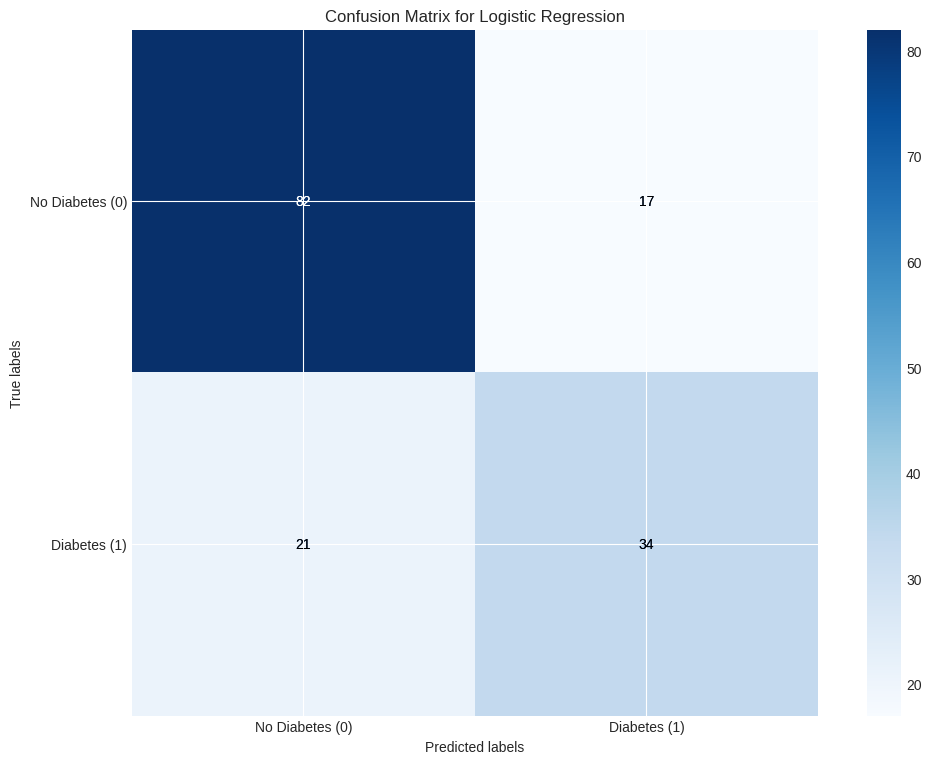

In [ ]:
cm = confusion_matrix(Y_test, y_predict2, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)


fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for Logistic Regression')


plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.yticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2. else 'black')

plt.show()

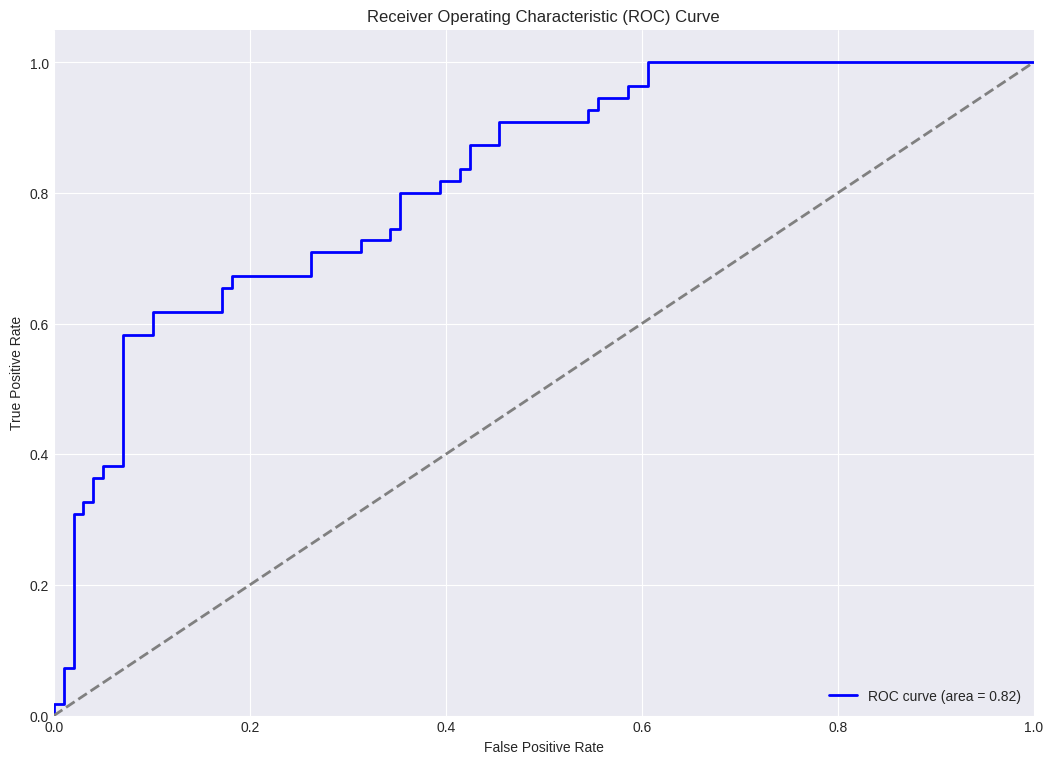

Model Summary:
ROC AUC: 0.8242424242424242


In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = roc_auc_score(Y_test, y_prob)
accuracy2 = accuracy_score(Y_test, y_predict2)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Podsumowanie modelu
print("Model Summary:")
print(f"ROC AUC: {roc_auc:}")

In [ ]:
print("Classification Report is:\n",classification_report(Y_test,y_predict2))
print("Confusion Matrix:\n",confusion_matrix(Y_test,y_predict1))
print("Training Score:\n",model.score(X_train,Y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(Y_test,y_predict1))
print("R2 score is:\n",r2_score(Y_test,y_predict1))

Classification Report is:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

Confusion Matrix:
 [[72 27]
 [37 18]]
Training Score:
 77.19869706840392
Mean Squared Error:
 0.4155844155844156
R2 score is:
 -0.8101010101010107


In [ ]:
accuracy2

0.7532467532467533

Wnioski: Model 3

Macierz Pomyłek:

Model poprawnie sklasyfikował
18 (TP) pozytywnych przypadków oraz
72 (TN) negatywnych przypadków.
Zanotowano
37 (FP) fałszywych pozytywów oraz
27 (FN) fałszywych negatywów, co może sugerować [możliwości do poprawy].

Krzywa ROC:

Wartość AUC wynosi
0.8424, co wskazuje na dobrą zdolność modelu do rozróżniania między klasami.

Raport z Modelu:

* Dokładność modelu wynosi 0.7532, co oznacza, że model poprawnie klasyfikuje większość przypadków.
* Czułość modelu wynosi 0.62, co oznacza, że model dobrze identyfikuje rzeczywiste pozytywne przypadki.
* Precyzja modelu wynosi 0.67, co wskazuje na wysoką dokładność w przewidywaniu pozytywnych przypadków.
* F1 Score wynosi 0.64, co świadczy o zrównoważonej wydajności modelu.

Model 3 ma wyższe parametry niz poprzednie modele więc możemy powiedzieć, że standaryzacja danych poprawiła nasz model.

## Tuning Hiperparametrów w modelu Regresji Logistycznej

In [ ]:
lr_model = LogisticRegression(random_state=42)
parameters = {'C': [0.1, 1, 10],
              'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(lr_model, parameters, cv=5).fit(X_train, Y_train)

best_lr_model = lr_grid.best_estimator_

print("Logistic Regression - Hyperparameter Optimization")
print(f"Best Parameters: {lr_grid.best_params_}")
print(f"Accuracy: {round(lr_grid.best_score_, 4)}")
print(f"Recall: {round(recall_score(best_lr_model.predict(X_test), Y_test), 4)}")
print(f"Precision: {round(precision_score(best_lr_model.predict(X_test), Y_test), 4)}")
print(f"F1: {round(f1_score(best_lr_model.predict(X_test), Y_test), 4)}")
print(f"AUC: {round(roc_auc_score(best_lr_model.predict(X_test), Y_test), 4)}")

Logistic Regression - Hyperparameter Optimization
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.7671
Recall: 0.6939
Precision: 0.6182
F1: 0.6538
AUC: 0.7469


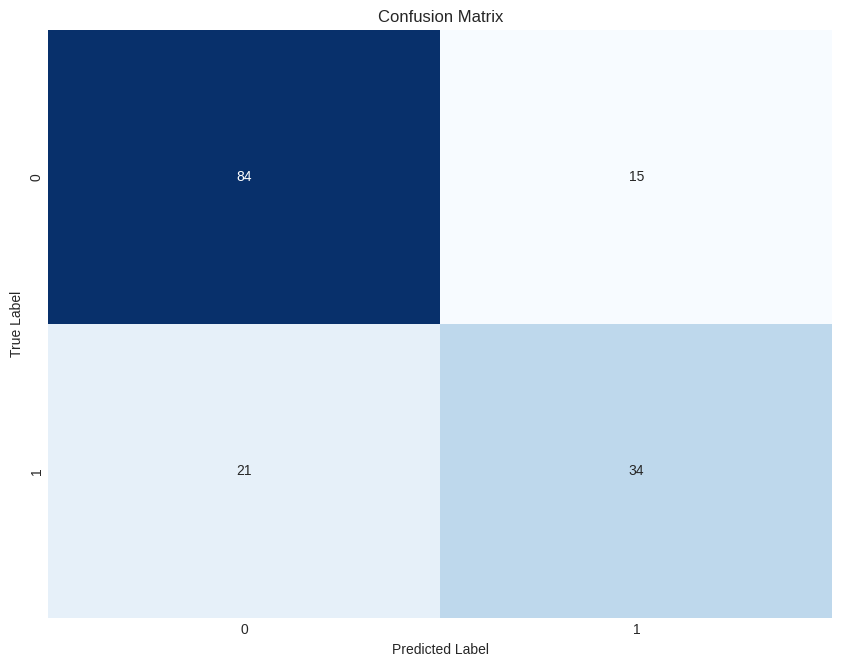

In [ ]:
y_pred = best_lr_model.predict(X_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

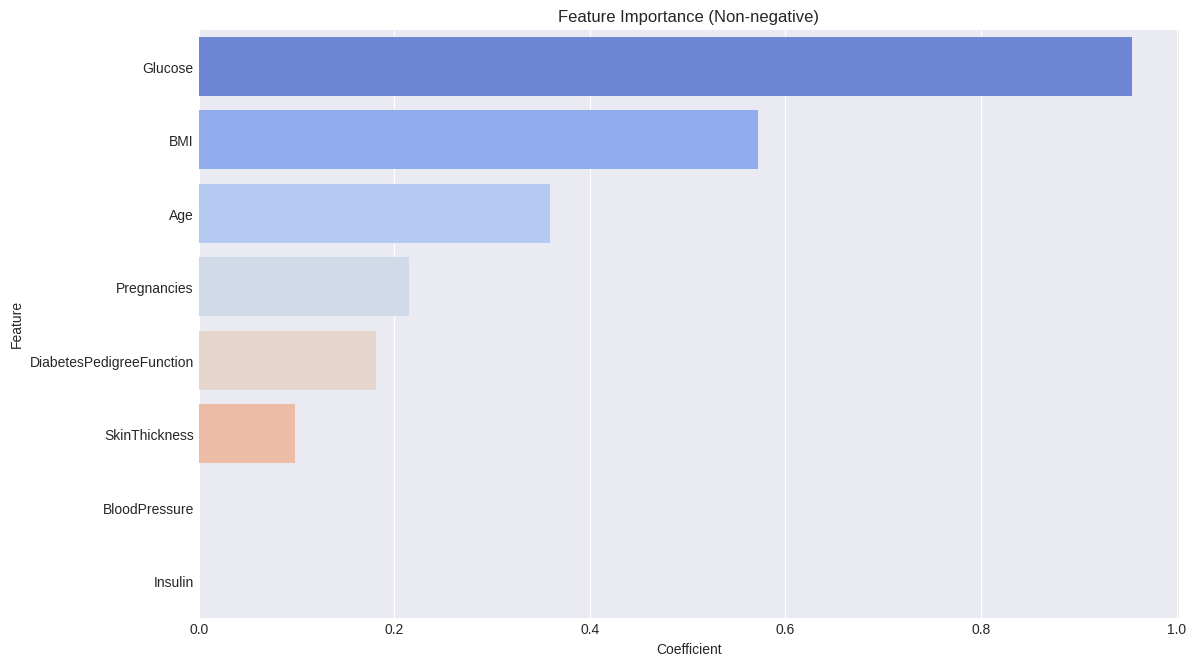

In [ ]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lr_model.coef_[0]
})

coefficients['Coefficient'] = coefficients['Coefficient'].apply(lambda x: max(0, x))

coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='coolwarm')
plt.title('Feature Importance (Non-negative)')
plt.show()

Wnioski: Tuning Hiperparametrów

Macierz Pomyłek:

Model poprawnie sklasyfikował
34 (TP) pozytywnych przypadków oraz
84 (T)N negatywnych przypadków.
Zanotowano
21 (FP) fałszywych pozytywów oraz
15 (FN) fałszywych negatywów, co może sugerować poprawna klasyfikacje, choc nie doskonałą.

Krzywa ROC:


* Dokładność modelu wynosi 0.7671, co oznacza, że model poprawnie klasyfikuje większość przypadków.
* Czułość modelu wynosi 0.6939, co oznacza, że model dobrze identyfikuje rzeczywiste pozytywne przypadki.
* Precyzja modelu wynosi 0.6182, co wskazuje na wysoką dokładność w przewidywaniu pozytywnych przypadków.
* F1 Score wynosi 0.6538, co świadczy o dobrej wydajności modelu.

Dokładność przy tuningu hiperparametrów jest troche wyższa niz w naszym modelu 3, ale precyjza troche niższa, zatem nasz model 3 ma prawie optymalne parametry.

## Model drzewa decyzyjnego


Utworzymy model drzewa decyzyjnego w celu porównania czy dokładnośc predykcji tego modelu będzie większa niż dokładność modelu Regresji Logistycznej

In [ ]:
# Model drzewa decyzyjnego
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

W tym przypadku działamy tak jak modelach regresji logistycznej ale nie będziemy rysować krzywej ROC

In [ ]:
# Predykcje i ocena modelu
y_predict3 = clf.predict(X_test)

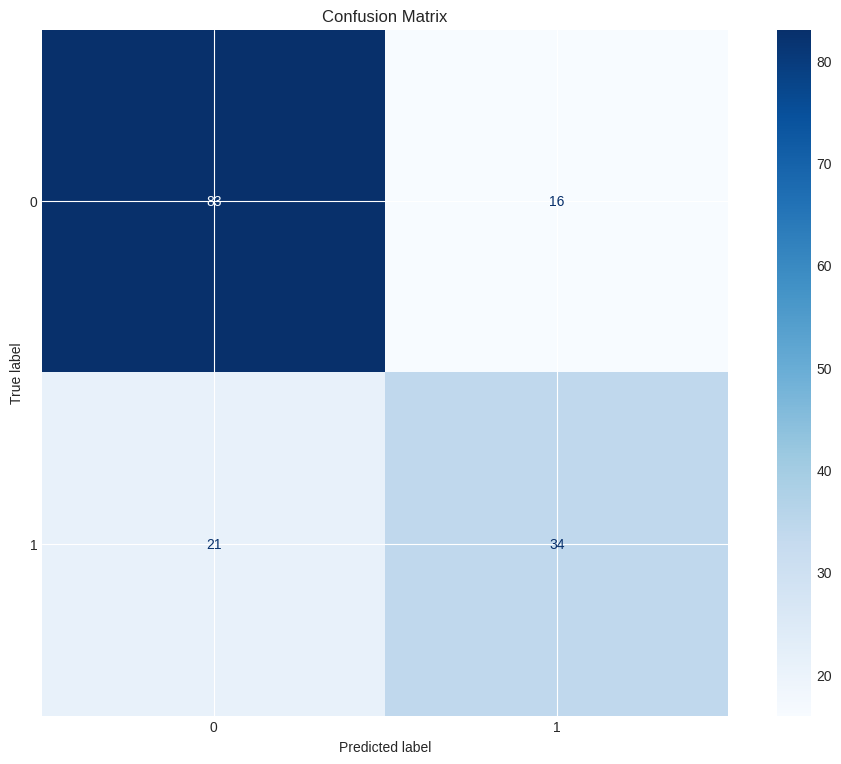

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(Y_test, y_predict3, labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix')
plt.show()

Możemy zwizualizować model drzewa decyzyjnego żeby zobaczyc jak wygląda nsze drzewo i jak przebiega nasza klasyfikacja

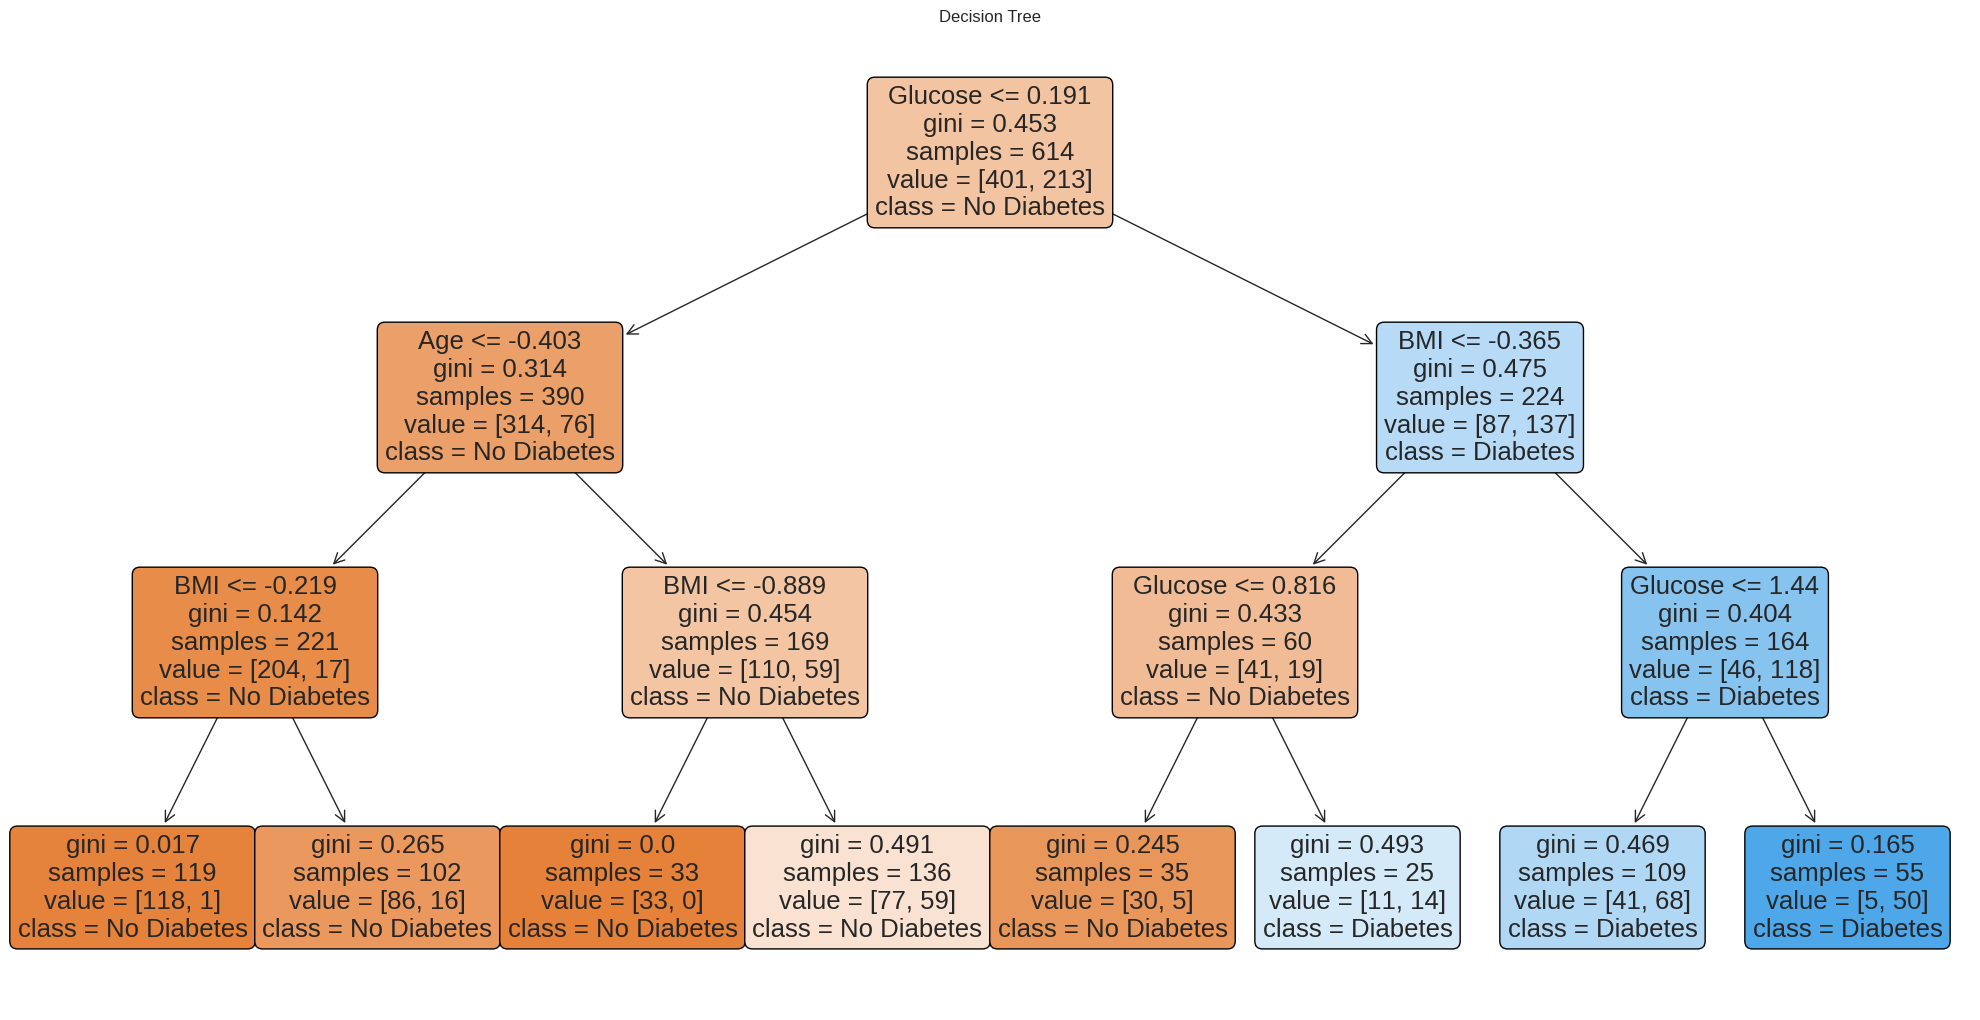

In [ ]:
# Wizualizacja drzewa decyzyjnego
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True, rounded=True)
plt.title('Decision Tree')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(Y_test, y_predict3))

# Wyświetlenie dokładności modelu
accuracy3 = accuracy_score(Y_test, y_predict3)
print(f"Model Accuracy: {accuracy3:}")

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

Model Accuracy: 0.7597402597402597


Wnioski: Model Drzewa Decyzyjnego

Macierz Pomyłek:

Model poprawnie sklasyfikował  
34 TP pozytywnych przypadków oraz
83 TN negatywnych przypadków.
Zanotowano
16 FP fałszywych pozytywów oraz
21 FN fałszywych negatywów, co może sugerować możliwości do poprawy.

Raport z modelu:

* Dokładność modelu wynosi 75.97%, co oznacza, że model poprawnie klasyfikuje większość przypadków.
* Czułość modelu wynosi
68%, co oznacza, że model dobrze identyfikuje rzeczywiste pozytywne przypadki.
* Precyzja modelu wynosi
62%, co wskazuje na przeciętną dokładność w przewidywaniu pozytywnych przypadków.
* F1 Score wynosi
0.65, co świadczy o średniej wydajności modelu.

## Algorytm DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

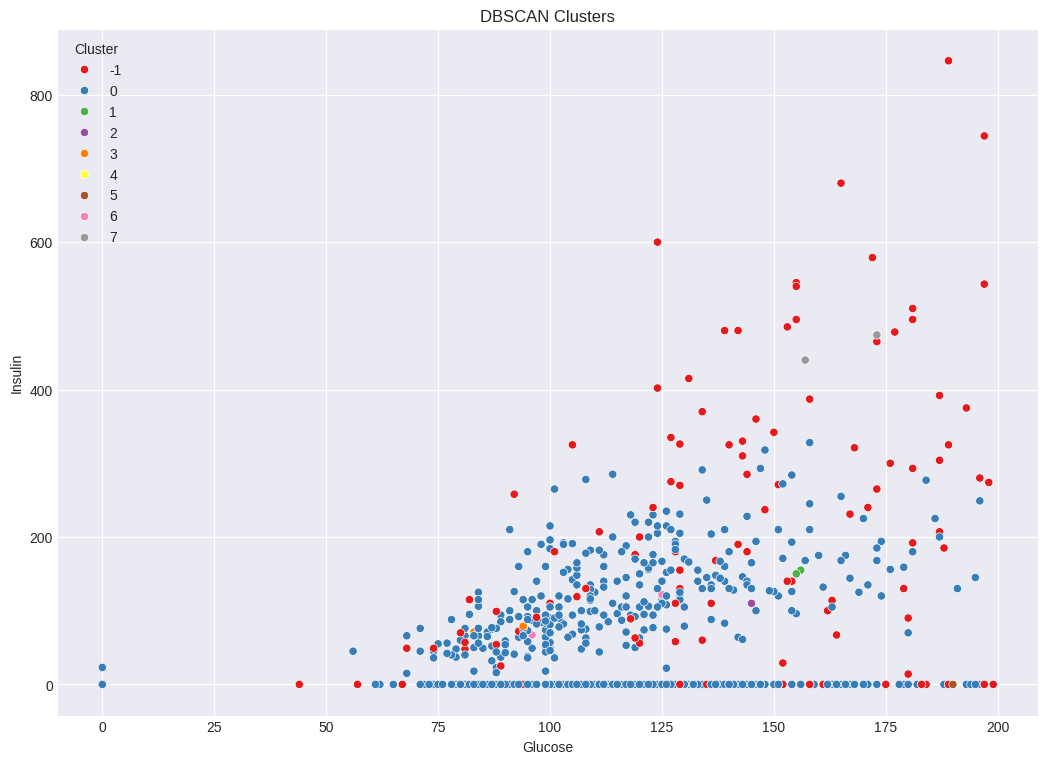

In [ ]:
# Standardyzacja danych dla DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Model DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=2)
dbscan.fit(X_scaled)

# Dodanie etykiet klastrów do DataFrame
df['Cluster'] = dbscan.labels_

# Wizualizacja klastrów
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Glucose', y='Insulin', hue='Cluster', palette='Set1')
plt.title('DBSCAN Clusters')
plt.xlabel('Glucose')
plt.ylabel('Insulin')
plt.legend(title='Cluster')
plt.show()

Interpretacja Klastrów:

Gęstość: DBSCAN identyfikuje klastry na podstawie gęstości punktów. Klaster jest zdefiniowany jako grupa punktów, które są blisko siebie (w promieniu epsilon, ϵ) i zawierają minimalną liczbę punktów (minPts).

Kształt: W przeciwieństwie do innych algorytmów, DBSCAN może wykrywać klastry o dowolnym kształcie i rozmiarze, nie wymagając uprzedniego określenia liczby klastrów.


Mały Rozrzut Punktów:

Homogeniczność Klastrów: Mały rozrzut punktów w klastrach wskazuje na homogeniczność danych w ramach klastrów. Punkty są blisko siebie, co sugeruje, że dane w ramach klastrów są do siebie bardzo podobne.

Wyraźne Granice: Mały rozrzut może również świadczyć o wyraźnych granicach między klastrami, co ułatwia identyfikację poszczególnych grup.

Wysoka Gęstość: Wysoka gęstość punktów w małych obszarach może świadczyć o skupiskach w danych, które DBSCAN skutecznie identyfikuje jako oddzielne klastry.

Wnioski:

Jeśli punkty są bardzo blisko siebie i nie tworzą wyraźnych klastró, może to świadczyć o nie istnieniu naturalnych grup w danych.



